<a href="https://colab.research.google.com/github/Ahmadar91/ML/blob/main/Lab_4_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [52]:
%matplotlib inline

In [ ]:
%pip install matplotlib 
%pip install pandas 
%pip install torch 
%pip install torchvision

In [54]:
from pandas import *
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math

In [56]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 10000
learning_rate = 0.01
momentum = 0.5

In [57]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_set = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size_train, shuffle=True
)

test_set = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size_test, shuffle=False
)

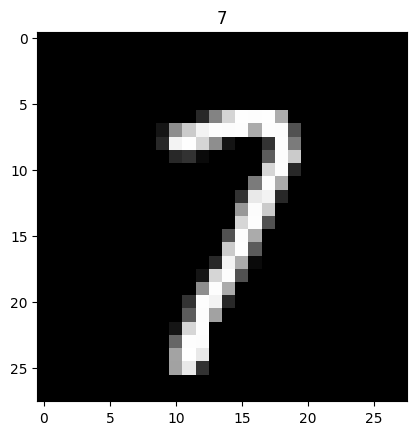

In [58]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

image = images[0]
label = labels[0]

image = image * 0.5 + 0.5

image = image.numpy()

plt.imshow(image.squeeze(), cmap="gray")

plt.title(str(label.item()))

plt.show()

In [68]:
class MyCNN(nn.Module):
    def __init__(self, kernel_size=2):
        super(MyCNN, self).__init__()
        self.kernel_size = kernel_size
        print("kernel size", self.kernel_size)
        input_size = 28
        output_channels_value = 3
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=output_channels_value,
            kernel_size=self.kernel_size,
        )
        self.pool = nn.MaxPool2d(self.kernel_size)
        conv_out_size = (input_size - self.kernel_size) + 1
        print(f"conv_out_size: {conv_out_size}")
        pool_out_size = ((conv_out_size - self.kernel_size) // self.kernel_size) + 1
        print(f"pool_out_size: {pool_out_size}")
        input_size_after_conv_and_pool = (
            output_channels_value * pool_out_size * pool_out_size
        )
        print("input_size_after_conv_and_pool", input_size_after_conv_and_pool)
        self.fc1 = nn.Linear(input_size_after_conv_and_pool, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        self.features = x  # Store the feature maps
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x

In [69]:
trainAccuracy = list()
testAccuracy = list()

model = MyCNN(5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

kernel size 5
conv_out_size: 24
pool_out_size: 4
input_size_after_conv_and_pool 48


In [66]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    return train_accuracy


def test(model, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    return test_accuracy


for epoch in range(n_epochs):
    train_accuracy = train(model, train_loader, criterion, optimizer)
    trainAccuracy.append(train_accuracy)

    test_accuracy = test(model, test_loader)
    testAccuracy.append(test_accuracy)

    print(
        f"Epoch {epoch+1}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%"
    )

print("Finished Training")

Epoch 1, Train Accuracy: 79.87%, Test Accuracy: 94.87%
Epoch 2, Train Accuracy: 95.36%, Test Accuracy: 96.77%
Epoch 3, Train Accuracy: 96.44%, Test Accuracy: 97.10%
Epoch 4, Train Accuracy: 96.98%, Test Accuracy: 97.37%
Epoch 5, Train Accuracy: 97.26%, Test Accuracy: 97.77%
Finished Training


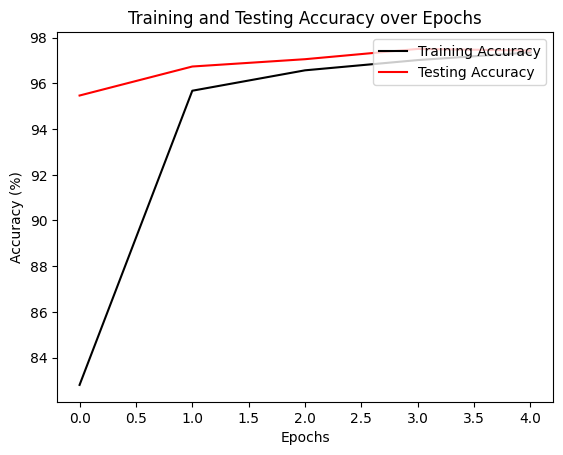

In [62]:
plt.plot(trainAccuracy, "k", label="Training Accuracy")
plt.plot(testAccuracy, "r", label="Testing Accuracy")

plt.title("Training and Testing Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(loc="upper right")

plt.show()

kernel size 2
conv_out_size: 27
pool_out_size: 13
input_size_after_conv_and_pool 2704
Epoch 1, Train Accuracy: 82.22%, Test Accuracy: 88.92%
Epoch 2, Train Accuracy: 91.94%, Test Accuracy: 93.85%
Epoch 3, Train Accuracy: 94.09%, Test Accuracy: 94.43%
Epoch 4, Train Accuracy: 95.57%, Test Accuracy: 96.08%
Epoch 5, Train Accuracy: 96.47%, Test Accuracy: 96.69%
Finished Training


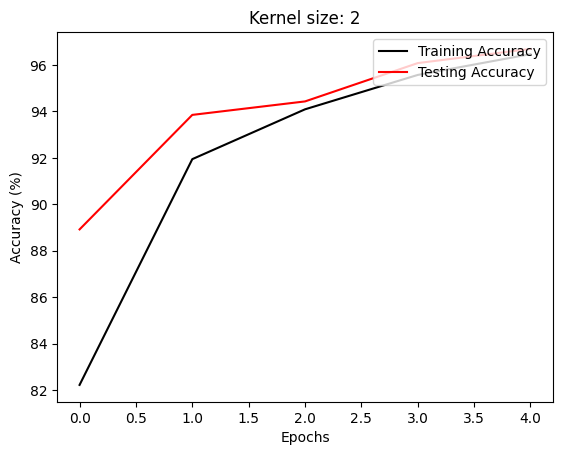

kernel size 3
conv_out_size: 26
pool_out_size: 8
input_size_after_conv_and_pool 1024
Epoch 1, Train Accuracy: 85.06%, Test Accuracy: 94.72%
Epoch 2, Train Accuracy: 95.28%, Test Accuracy: 96.56%
Epoch 3, Train Accuracy: 96.58%, Test Accuracy: 97.14%
Epoch 4, Train Accuracy: 97.24%, Test Accuracy: 97.53%
Epoch 5, Train Accuracy: 97.60%, Test Accuracy: 97.44%
Finished Training


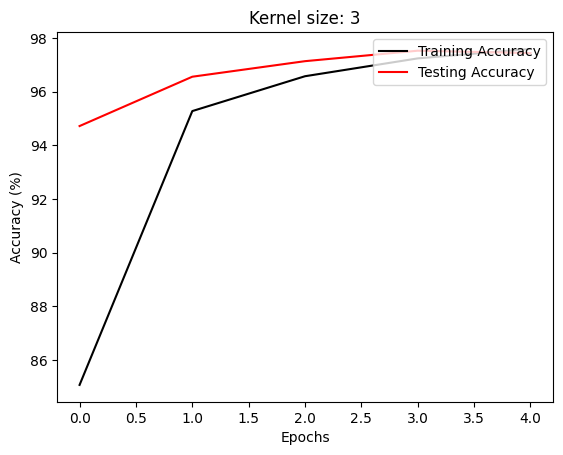

kernel size 4
conv_out_size: 25
pool_out_size: 6
input_size_after_conv_and_pool 576
Epoch 1, Train Accuracy: 83.26%, Test Accuracy: 95.55%
Epoch 2, Train Accuracy: 95.88%, Test Accuracy: 96.90%
Epoch 3, Train Accuracy: 96.93%, Test Accuracy: 97.35%
Epoch 4, Train Accuracy: 97.42%, Test Accuracy: 97.49%
Epoch 5, Train Accuracy: 97.71%, Test Accuracy: 97.79%
Finished Training


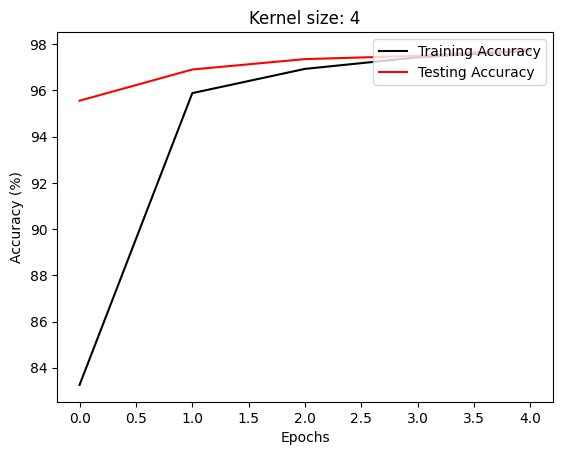

kernel size 5
conv_out_size: 24
pool_out_size: 4
input_size_after_conv_and_pool 256
Epoch 1, Train Accuracy: 79.47%, Test Accuracy: 94.34%
Epoch 2, Train Accuracy: 95.17%, Test Accuracy: 96.61%
Epoch 3, Train Accuracy: 96.34%, Test Accuracy: 96.98%
Epoch 4, Train Accuracy: 96.95%, Test Accuracy: 96.93%
Epoch 5, Train Accuracy: 97.25%, Test Accuracy: 97.58%
Finished Training


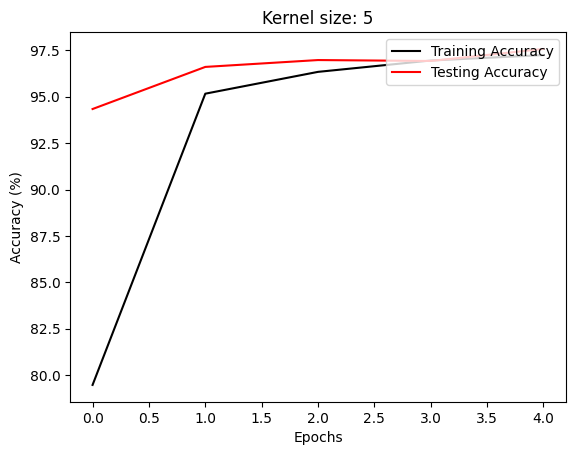

In [63]:
kernelSizes = [2, 3, 4, 5]

for kernelSize in kernelSizes:
    trainAccuracy = list()
    testAccuracy = list()
    # instantiate your CNN using kernel size
    trainAccuracy = list()
    testAccuracy = list()

    model = MyCNN(kernelSize)
    # define optimizer and loss function
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    # train and test - you can copy the code
    for epoch in range(n_epochs):
        train_accuracy = train(model, train_loader, criterion, optimizer)
        trainAccuracy.append(train_accuracy)

        test_accuracy = test(model, test_loader)
        testAccuracy.append(test_accuracy)

        print(
            f"Epoch {epoch+1}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%"
        )

    print("Finished Training")
    # now plot this
    plt.plot(trainAccuracy, "k", label="Training Accuracy")
    plt.plot(testAccuracy, "r", label="Testing Accuracy")
    plt.title("Kernel size: " + str(kernelSize))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc="bottom right")
    plt.show()

Kernel Values:
[[[[ 0.04158497 -0.13688958 -0.17849039 -0.1505671  -0.12388942]
   [-0.0900472  -0.04072385  0.07536472 -0.1500577  -0.17555998]
   [ 0.11855288  0.03986008  0.03124079 -0.05030903  0.10528795]
   [ 0.0858468   0.1064636   0.142841    0.1236154  -0.07282993]
   [-0.16214995  0.12314634  0.03015451 -0.14652646 -0.06097345]]]


 [[[-0.02610645  0.14664795  0.009918    0.13086434  0.06508102]
   [-0.01128986 -0.05450396  0.18600692  0.06514369 -0.08818664]
   [-0.08327496  0.07812218 -0.07802248 -0.0755321  -0.05592962]
   [ 0.0995592   0.17453207  0.19954835  0.135345    0.04103398]
   [-0.1801918  -0.12766585 -0.14901109  0.14045872 -0.04285593]]]


 [[[-0.18876849  0.03757071 -0.02545819 -0.10914101  0.1900341 ]
   [-0.19090004  0.18258958 -0.05738966 -0.0619944  -0.04713881]
   [-0.1525803  -0.05320697  0.17008568 -0.03674202  0.11439766]
   [-0.17737551 -0.05446503  0.18937902 -0.1594624   0.14232577]
   [ 0.15326928 -0.06275468 -0.09130676 -0.02868767 -0.02304944]]]]

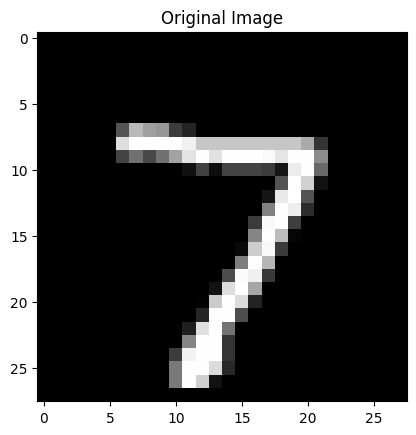

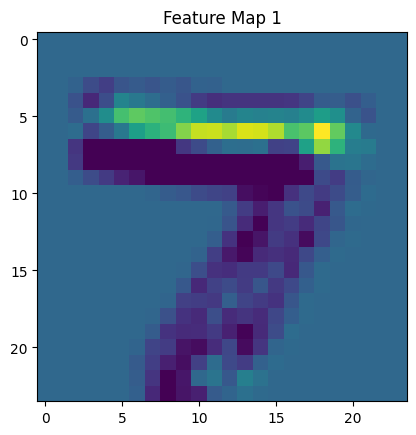

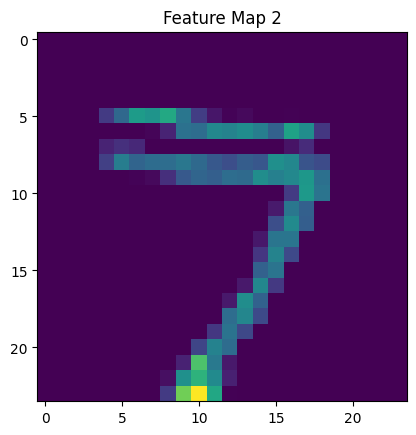

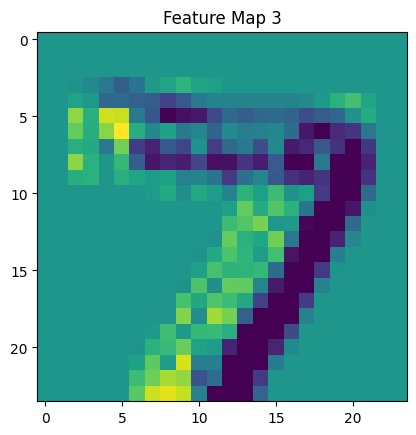

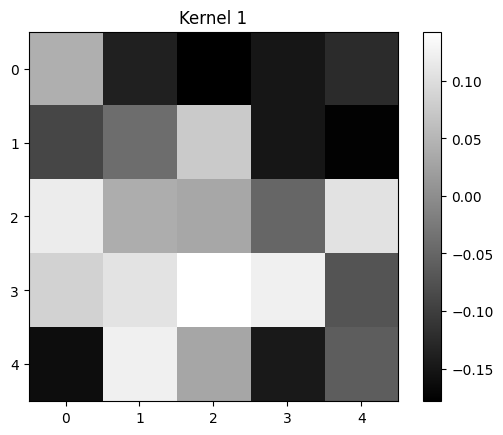

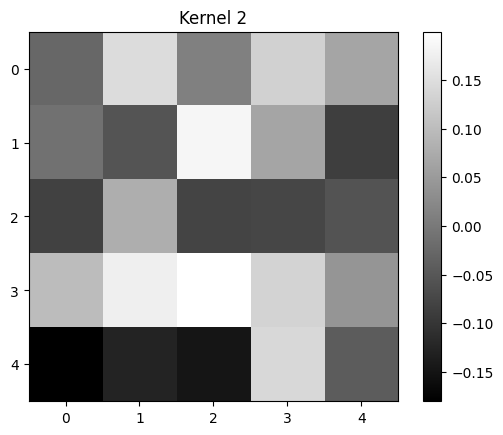

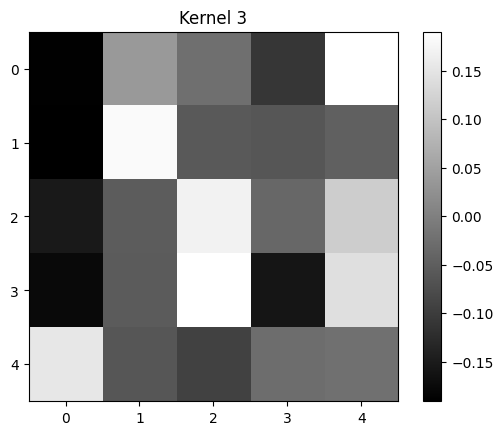

In [83]:
import matplotlib.pyplot as plt

# Assume `model` is your trained model, and `data` is your dataset
model.eval()  # Set the model to evaluation mode
image, label = next(
    iter(test_loader)
)  # Get a batch of images and labels from your dataset

# Select the first image from the batch
input_image = image[0].unsqueeze(0)

# Forward pass
output = model(input_image)

# Get the feature maps
feature_maps = model.features.squeeze(0).detach().numpy()
# Assuming `model` is an instance of your model class
kernel_values = model.conv1.weight.detach().numpy()
print("Kernel Values:")
print(kernel_values)

# Plot the original image
plt.imshow(input_image.squeeze(0).squeeze(0), cmap="gray")
plt.title("Original Image")
plt.show()

# Plot each feature map
num_feature_maps = feature_maps.shape[0]
for i in range(num_feature_maps):
    plt.imshow(feature_maps[i], cmap="viridis")
    plt.title(f"Feature Map {i+1}")
    plt.show()

    # Number of out_channels in conv1 layer
num_kernels = kernel_values.shape[0]

for i in range(num_kernels):
    plt.imshow(kernel_values[i, 0], cmap="gray")  # assuming in_channels = 1
    plt.title(f"Kernel {i+1}")
    plt.colorbar()
    plt.show()

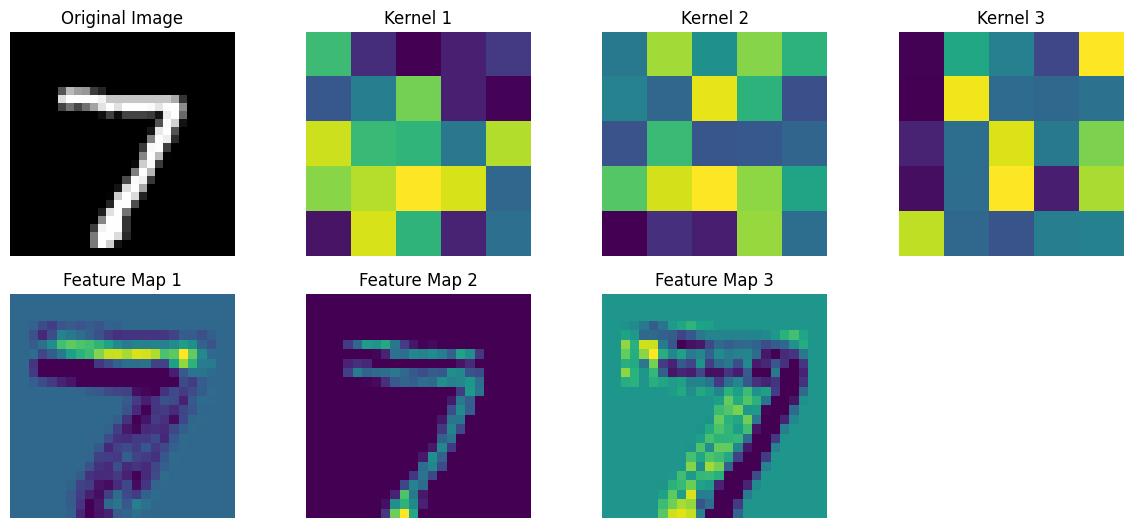

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming model is an instance of your model class and already trained
kernel_values = model.conv1.weight.detach().numpy()

# Extracting one image from the test_loader
image, _ = next(iter(test_loader))  # get one batch of images
image = image[0].unsqueeze(0)  # select the first image of the batch

# Perform a forward pass to get the features
model(image)
feature_maps = model.features.squeeze(0).detach().numpy()

# Number of out_channels in conv1 layer
num_kernels = kernel_values.shape[0]
num_feature_maps = feature_maps.shape[0]

# Define plot structure
plt.figure(figsize=(12, 8))

# Plot original image
plt.subplot(3, max(num_kernels, num_feature_maps) + 1, 1)
plt.imshow(image.squeeze().numpy(), cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Plot the kernel values
for i in range(num_kernels):
    plt.subplot(3, max(num_kernels, num_feature_maps) + 1, i + 2)
    plt.imshow(kernel_values[i, 0], cmap="viridis")  # assuming in_channels = 1
    plt.title(f"Kernel {i+1}")
    plt.axis("off")

# Plot the feature maps
for i in range(num_feature_maps):
    plt.subplot(
        3,
        max(num_kernels, num_feature_maps) + 1,
        i + max(num_kernels, num_feature_maps) + 2,
    )
    plt.imshow(feature_maps[i], cmap="viridis")
    plt.title(f"Feature Map {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

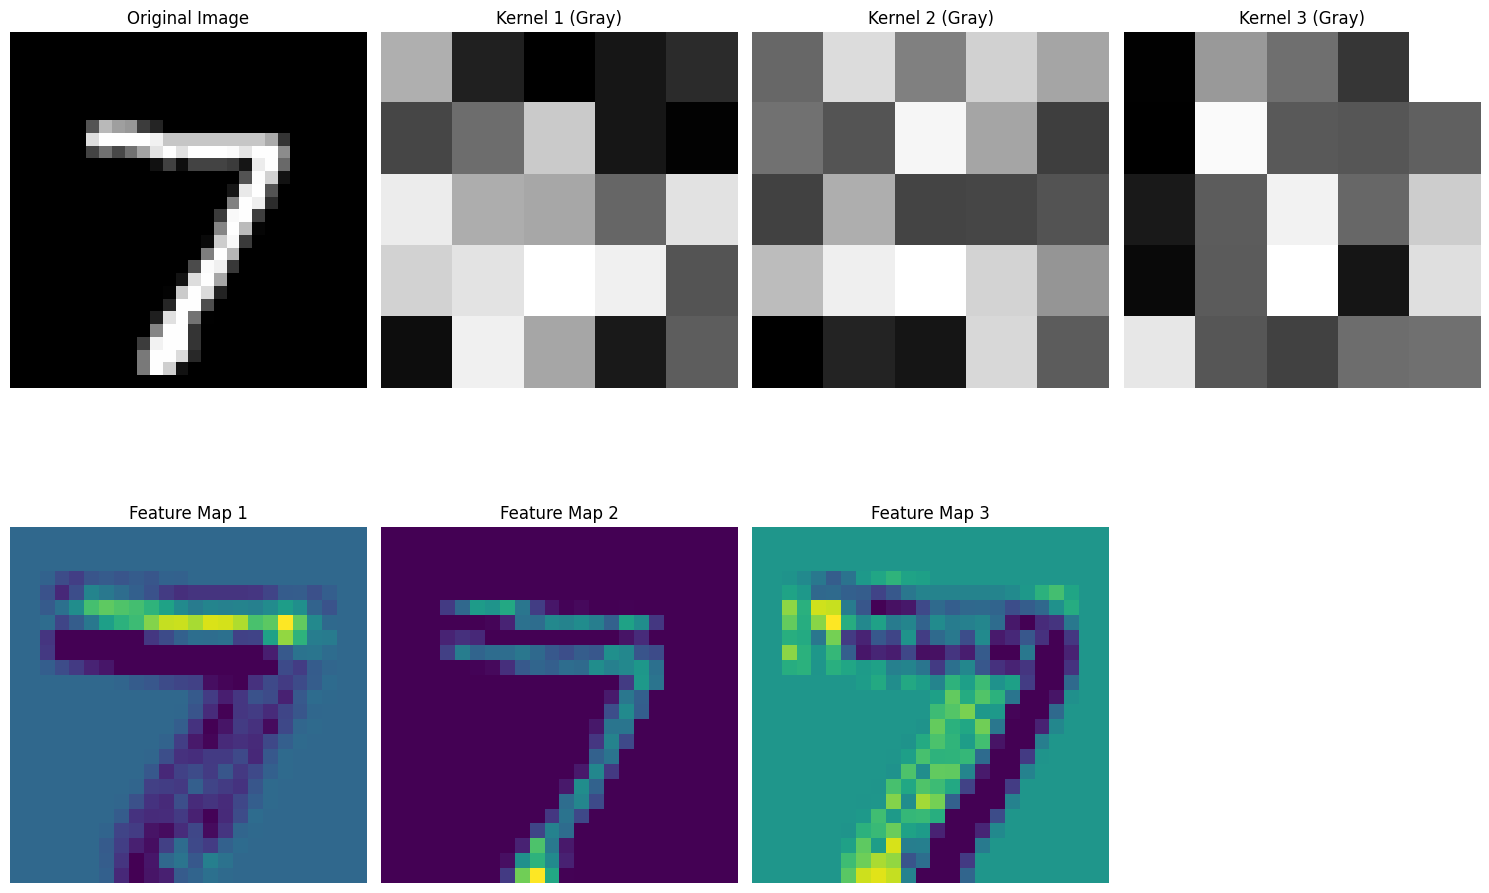

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Assume `model` is your trained model
model.eval()  # Set the model to evaluation mode

# Extracting one image from the test_loader
image, _ = next(iter(test_loader))  # get one batch of images
input_image = image[0].unsqueeze(0)  # select the first image of the batch

# Forward pass to get the features
output = model(input_image)
feature_maps = model.features.squeeze(0).detach().numpy()

# Extract kernel values
kernel_values = model.conv1.weight.detach().numpy()

# Number of out_channels in conv1 layer
num_kernels = kernel_values.shape[0]
num_feature_maps = feature_maps.shape[0]

# Define plot structure
plt.figure(figsize=(15, 15))

# Plot original image
plt.subplot(3, max(num_kernels, num_feature_maps) + 1, 1)
plt.imshow(input_image.squeeze().numpy(), cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Plot the kernel values
for i in range(num_kernels):
    plt.subplot(3, max(num_kernels, num_feature_maps) + 1, i + 2)
    plt.imshow(kernel_values[i, 0], cmap="gray")  # assuming in_channels = 1
    plt.title(f"Kernel {i+1} (Gray)")
    plt.axis("off")

# Plot the feature maps
for i in range(num_feature_maps):
    plt.subplot(
        3,
        max(num_kernels, num_feature_maps) + 1,
        i + max(num_kernels, num_feature_maps) + 2,
    )
    plt.imshow(feature_maps[i], cmap="viridis")
    plt.title(f"Feature Map {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()